In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re

url = 'https://raw.githubusercontent.com/Haeeshart/Python-for-Biologists/refs/heads/main/Growth%20curve.csv'
df = pd.read_csv(url)
df.head()


,Hours,WT 1,WT 2,WT 3,DHNOX 1,DHNOX 2,DHNOX 3
0,0,0.044,0.045,0.050,0.043,0.044,0.045
1,4,0.281,0.246,0.244,0.218,0.233,0.239
2,8,0.569,0.525,0.531,0.620,0.567,0.522
3,12,0.812,0.788,0.748,0.744,0.782,0.730
4,16,1.191,1.071,1.063,1.252,1.086,1.042


In [2]:
time_col = df.columns[0]                       # first column (e.g., 'Hours')
value_cols = df.columns[1:]                    # replicate columns

long_df = df.melt(id_vars=[time_col],
                  value_vars=value_cols,
                  var_name='StrainRep',
                  value_name='OD')

# Remove trailing replicate number to get the base strain name (e.g., "WT 1" -> "WT")
long_df['Strain'] = long_df['StrainRep'].str.replace(r'\s*\d+$', '', regex=True)


# Remove trailing replicate number to get the base strain name (e.g., "DHNOX 1"
# -> "DHNOX")
long_df['Strain'] = long_df['StrainRep'].str.replace(r'\s*\d+$', '', regex=True)

# mean and SEM = std/sqrt(n) for each time × strain
summary = (long_df
           .groupby([time_col, 'Strain'], as_index=False)
           .agg(mean=('OD', 'mean'),
                sem =('OD', lambda x: x.std(ddof=1) / np.sqrt(len(x)))))

print("Summary (first rows):\n", summary.head(), "\n")

Summary (first rows):
    Hours Strain      mean       sem
0      0  DHNOX  0.044000  0.000577
1      0     WT  0.046333  0.001856
2      4  DHNOX  0.230000  0.006245
3      4     WT  0.257000  0.012014
4      8  DHNOX  0.569667  0.028322 



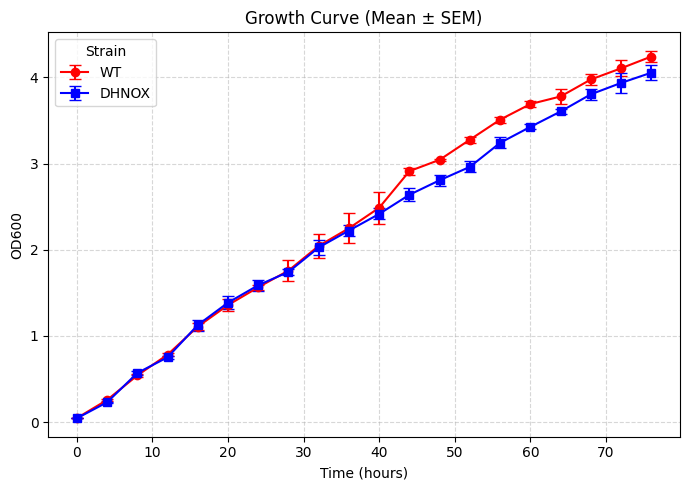

In [3]:
# Plot mean curves with SEM error bars ===
plt.figure(figsize=(7,5))

# WT:
plt.errorbar(summary[summary['Strain']=='WT'][time_col],
             summary[summary['Strain']=='WT']['mean'],
             yerr=summary[summary['Strain']=='WT']['sem'],
             fmt='-o', capsize=4, color='Red', label='WT')

# ΔHNOX:
plt.errorbar(summary[summary['Strain']=='DHNOX'][time_col],
             summary[summary['Strain']=='DHNOX']['mean'],
             yerr=summary[summary['Strain']=='DHNOX']['sem'],
             fmt='-s', capsize=4, color='Blue', label='DHNOX')

plt.xlabel("Time (hours)")
plt.ylabel("OD600")
plt.title("Growth Curve (Mean ± SEM)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Strain")
plt.tight_layout()
plt.show()

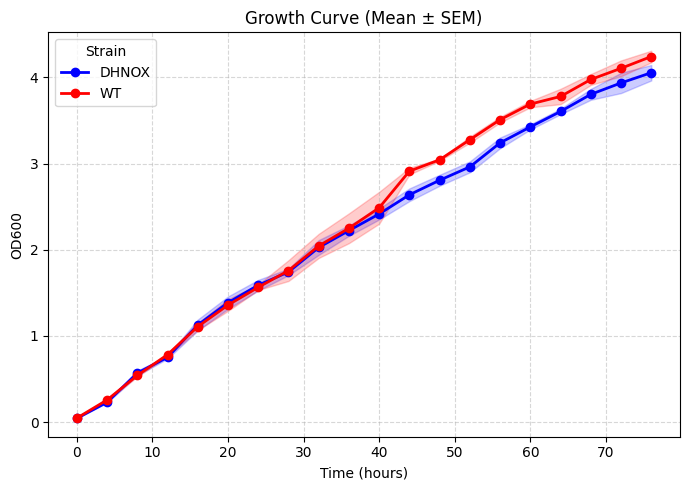

In [4]:
# Plot mean curves with SEM shading and custom colors ===
plt.figure(figsize=(7,5))

# Define colors for each strain
color_map = {
    'WT': 'Red',
    'DHNOX': 'Blue',
       # handles alternate delta symbol
}

for strain, sub in summary.groupby('Strain'):
    sub = sub.sort_values(time_col)
    x = sub[time_col].values
    y = sub['mean'].values
    e = sub['sem'].values

    # Pick color (default gray if strain not in color_map)
    color = color_map.get(strain, 'gray')

    # Plot line + markers
    plt.plot(x, y, marker='o', label=strain, color=color, linewidth=2)

    # SEM shading
    plt.fill_between(x, y - e, y + e, alpha=0.2, color=color)

plt.xlabel("Time (hours)")
plt.ylabel("OD600")
plt.title("Growth Curve (Mean ± SEM)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Strain")
plt.tight_layout()
plt.show()

# Line plot shows that the growth curve of WT and HNOX KO started off same but at about 45hours WT growth bacame slightly
# higher than deleted hnox which means that there is a slight difference in growth between WT and deleted hnox